In [61]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import mysql_conn as mc
import statsmodels.api as sm

sns.set_style("white")

In [2]:
conn = mc.connect()

Please provide your password········


# Black Friday promotion analysis

(Today: August 2018)

Olist ran a Black Friday campaign on Nov. 24th 2017. The campaign lasted for a week. 

The marketing team approaches you and asks if we should run the campaign again, this year.

## Get revenue data

In [3]:
query = """
SELECT
    DATE_SUB(DATE(o.order_purchase_timestamp),
        INTERVAL IF((DAYOFWEEK(DATE(o.order_purchase_timestamp)) - 2) = -1,
            6,
            DAYOFWEEK(DATE(o.order_purchase_timestamp)) - 2) DAY)   AS week_id,
    SUM(oi.price)                                                   AS revenue
FROM order_items oi
    JOIN orders o
    ON oi.order_id = o.order_id
WHERE
    o.order_purchase_timestamp > '2017-01-02'
    AND o.order_purchase_timestamp < '2018-09-03'
GROUP BY 1
ORDER BY 1;
"""

weekly_rev = pd.read_sql(query, conn)

In [4]:
weekly_rev.head()

,week_id,revenue
0,2017-01-02,3374.759989
1,2017-01-09,12937.239933
2,2017-01-16,24310.460104
3,2017-01-23,57773.149855
4,2017-01-30,71710.339832


In [5]:
weekly_rev.dtypes

week_id     object
revenue    float64
dtype: object

In [6]:
weekly_rev["week_id"] = pd.to_datetime(weekly_rev["week_id"])

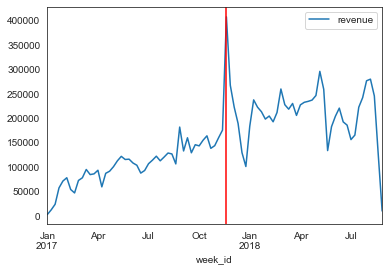

In [7]:
ax = weekly_rev.set_index("week_id").plot();
ax.axvline("2017-11-20", color="r");

# Approach 1:

Compare the week with Black Friday promotion to the week prior

In [8]:
bf_week = "2017-11-20"
prior_week = "2017-11-13"

In [9]:
weekly_rev.loc[weekly_rev["week_id"].between(prior_week, bf_week)]

,week_id,revenue
45,2017-11-13,175819.690094
46,2017-11-20,407169.060410


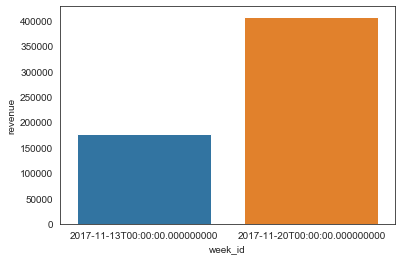

In [10]:
sns.barplot(data=weekly_rev.loc[weekly_rev["week_id"].between(prior_week, bf_week)],
            x="week_id",
            y="revenue");

Baseline: The revenue in the prior week.

=> We are assuming that the revenue in the week of 2017-11-20 would have been the same as in the prior week, if we wouldn't have run a Black Friday promotion

In [11]:
weekly_rev.loc[weekly_rev["week_id"] == prior_week, "revenue"].values[0]

175819.69009399414

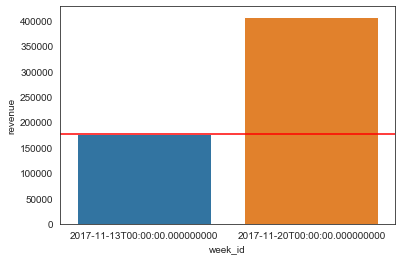

In [12]:
ax = sns.barplot(data=weekly_rev.loc[weekly_rev["week_id"].between(prior_week, bf_week)],
                 x="week_id",
                 y="revenue");

ax.axhline(weekly_rev.loc[weekly_rev["week_id"] == prior_week, "revenue"].values[0], color="r");

Calculate the attributable revenue for the Black Friday campaign

In [13]:
rev_prior_week = weekly_rev.loc[weekly_rev["week_id"] == prior_week, "revenue"].values[0]
rev_bf_week = weekly_rev.loc[weekly_rev["week_id"] == bf_week, "revenue"].values[0]

In [14]:
abs_diff = rev_bf_week - rev_prior_week
rel_diff = (rev_bf_week / rev_prior_week) - 1

In [15]:
print(f"""The revenue for the week including the Black Friday promotion increased by {round(rel_diff * 100, 2)}% 
compared to the prior week. Assuming the Black Friday promotion accounts for the entire difference, we were 
able to increase our revenue by {round(abs_diff, 2)} Reais""")

The revenue for the week including the Black Friday promotion increased by 131.58% 
compared to the prior week. Assuming the Black Friday promotion accounts for the entire difference, we were 
able to increase our revenue by 231349.37 Reais


**Conclusion: We should definitely run the campaign again!**

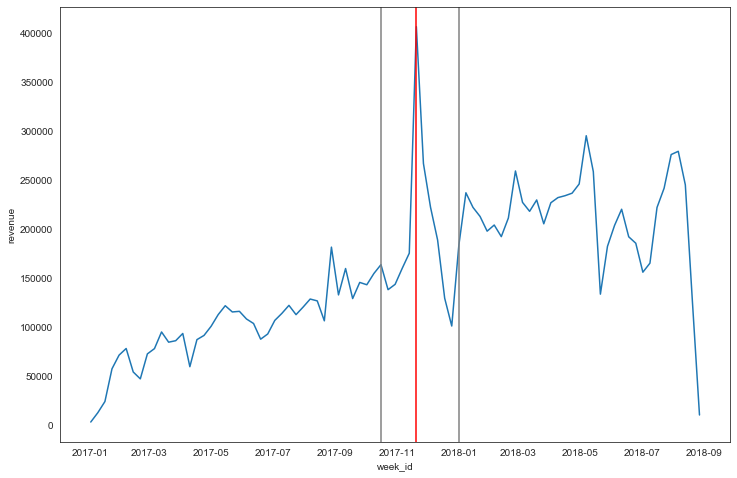

In [16]:
fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(data=weekly_rev,
             x="week_id",
             y="revenue",
             ax=ax);

ax.axvline(pd.to_datetime("2017-11-20"), color="r");
ax.axvline(pd.to_datetime("2017-10-16"), color="grey");
ax.axvline(pd.to_datetime("2018-01-01"), color="grey");

We can see that the week of the Black Friday campaign significantly increased our revenue. The graph however, suggests that devenue declined to a lower level than before, in the few weeks after the promotion. The same might apply to a few weeks prior to the promotion. One possible explanation is that consumers pre- (hangover) or postponed their purchase decision in anticipation of paying less during the Black Friday promotion. 

# Approach 2:

Consider a change in comsumer's purchase decision by including weeks prior and after the Black Friday promotion

In [17]:
lb = "2017-10-16"
ub = "2017-12-25"

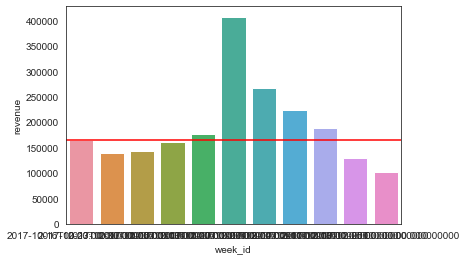

In [18]:
ax = sns.barplot(data=weekly_rev.loc[weekly_rev["week_id"].between(lb, ub)],
                 x="week_id",
                 y="revenue");

ax.axhline(weekly_rev.loc[weekly_rev["week_id"] == lb, "revenue"].values[0], color="r");

In [32]:
first_week = "2017-10-23"
app_2 = weekly_rev.loc[weekly_rev["week_id"].between(first_week, ub)].copy()

In [34]:
# establish the baseline
weekly_rev.loc[weekly_rev["week_id"] == lb, "revenue"].values[0]

164132.88989830017

In [36]:
app_2 = app_2.assign(baseline=weekly_rev.loc[weekly_rev["week_id"] == lb, "revenue"].values[0])
app_2

,week_id,revenue,baseline
42,2017-10-23,138558.520192,164132.889898
43,2017-10-30,144022.130485,164132.889898
44,2017-11-06,160327.020368,164132.889898
45,2017-11-13,175819.690094,164132.889898
46,2017-11-20,407169.060410,164132.889898
47,2017-11-27,267420.659656,164132.889898
48,2017-12-04,222805.700109,164132.889898
49,2017-12-11,189337.499647,164132.889898
50,2017-12-18,129878.209996,164132.889898
51,2017-12-25,101439.800245,164132.889898


In [39]:
# calculate the difference
app_2 = app_2.assign(abs_diff=app_2["revenue"] - app_2["baseline"])
app_2

,week_id,revenue,baseline,abs_diff
42,2017-10-23,138558.520192,164132.889898,-25574.369706
43,2017-10-30,144022.130485,164132.889898,-20110.759413
44,2017-11-06,160327.020368,164132.889898,-3805.869530
45,2017-11-13,175819.690094,164132.889898,11686.800196
46,2017-11-20,407169.060410,164132.889898,243036.170512
47,2017-11-27,267420.659656,164132.889898,103287.769757
48,2017-12-04,222805.700109,164132.889898,58672.810211
49,2017-12-11,189337.499647,164132.889898,25204.609748
50,2017-12-18,129878.209996,164132.889898,-34254.679902
51,2017-12-25,101439.800245,164132.889898,-62693.089653


In [40]:
app_2["abs_diff"].sum()

295449.39221954346

In [41]:
abs_diff_2 = app_2["abs_diff"].sum()
rel_diff_2 = app_2["abs_diff"].sum() / app_2["revenue"].sum()

In [42]:
print(f"""The revenue for the weeks influenced by the Black Friday promotion increased by {round(rel_diff_2 * 100, 2)}% 
compared to our baseline. Assuming the Black Friday promotion accounts for the entire difference, we were 
able to increase our revenue by {round(abs_diff_2, 2)} Reais""")

The revenue for the weeks influenced by the Black Friday promotion increased by 15.25% 
compared to our baseline. Assuming the Black Friday promotion accounts for the entire difference, we were 
able to increase our revenue by 295449.39 Reais


**Conclusion: We should definitely run the campaign again!**

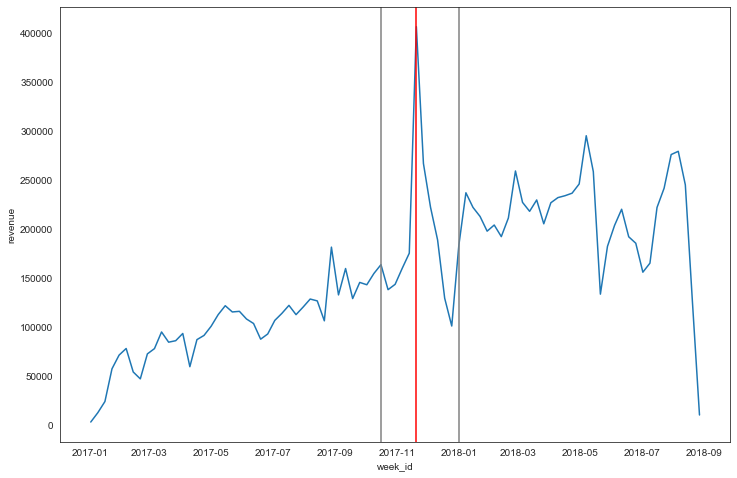

In [43]:
fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(data=weekly_rev,
             x="week_id",
             y="revenue",
             ax=ax);

ax.axvline(pd.to_datetime("2017-11-20"), color="r");
ax.axvline(pd.to_datetime("2017-10-16"), color="grey");
ax.axvline(pd.to_datetime("2018-01-01"), color="grey");

# Approach 3: Accounting for trend

So far, we have used one time period prior to the affected time range as a benchmark for predicted revenue (baseline). As can be seen clearly in the graph, revenue has had a positive trend when looking at the data from Jan 2017 until Oct 2017. In case there is in fact a positive trend, we might have overestimated the impact of the Black Friday campaign as part of the increase in revenue could plausibly be attributed to the general growth. 

In the following, we want to model `revenue` as a linear function that depends on time, so that we can account for the trend.

$revenue_t = c + t * trend$

$y_t = c + t * trend$

We are finding the best 'fitted line' to predict our baseline

- 1. Get data from 'before black friday impact date range'
- 2. Calculate parameters for model
- 3. Predict revenue for 'black friday impact date range' -> Baseline
- 4. Calculate the difference

**1. Get data from 'before black friday impact date range'**

In [46]:
first_week = "2017-10-16"
app_3 = weekly_rev.loc[weekly_rev["week_id"] <= first_week]

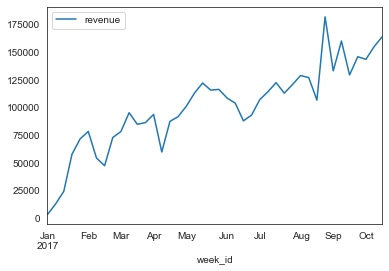

In [48]:
app_3.set_index("week_id").plot();

In [52]:
app_3 = app_3.assign(t=range(1, len(app_3) + 1))

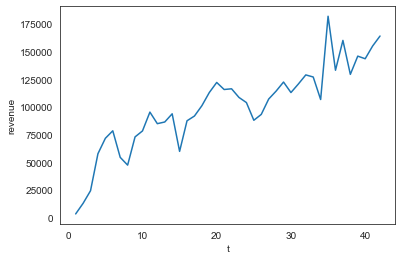

In [55]:
sns.lineplot(data=app_3,
             x="t",
             y="revenue");

In [57]:
app_3.head()

,week_id,revenue,t
0,2017-01-02,3374.759989,1
1,2017-01-09,12937.239933,2
2,2017-01-16,24310.460104,3
3,2017-01-23,57773.149855,4
4,2017-01-30,71710.339832,5


In [60]:
app_3 = app_3.assign(const=1)

In [63]:
X = app_3[["const", "t"]]
y = app_3["revenue"]

lin_reg = sm.OLS(y, X)
results = lin_reg.fit()

In [64]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     160.5
Date:                Mon, 29 Jun 2020   Prob (F-statistic):           1.39e-15
Time:                        15:10:13   Log-Likelihood:                -469.09
No. Observations:                  42   AIC:                             942.2
Df Residuals:                      40   BIC:                             945.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        3.95e+04   5522.229      7.152      0.000    2.83e+04    5.07e+04
t           2834.8026    223.741     12.670      0.000    2382.604    3287.001
==============================================================================
Omnibus:                        0.090   Durbin-Watson:                   1.341
Prob(Omnibus):                  0.956   Jarque-Bera (JB):                0.072
Skew:                          -0.070   Prob(JB):                        0.965
Kurtosis:                       2.854   Cond. No.                         50.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$revenue_t = 39500 + 2834.8 * t$

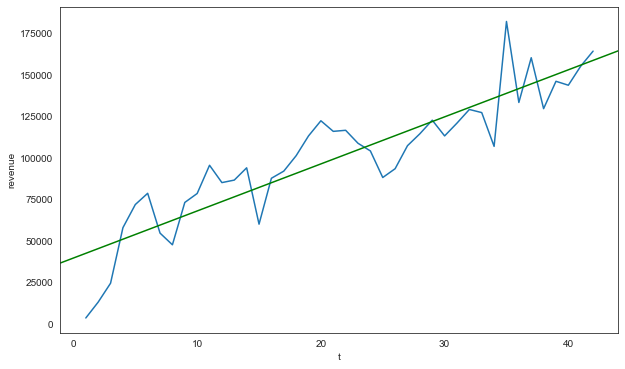

In [67]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=app_3,
             x="t",
             y="revenue");

sm.graphics.abline_plot(model_results=results, color="green", ax=ax);

In [71]:
app_3 = app_3.assign(pred_revenue=results.predict(X))

In [73]:
def fit_values(t):
    return 39500 + (2834.8 * t)

In [76]:
fit_values(5)

53674.0

In [78]:
app_3 = app_3.assign(manual_pred_revenue=app_3["t"].apply(fit_values))

In [79]:
app_3

,week_id,revenue,t,const,pred_revenue,manual_pred_revenue
0,2017-01-02,3374.759989,1,1,42331.374024,42334.8
1,2017-01-09,12937.239933,2,1,45166.176602,45169.6
2,2017-01-16,24310.460104,3,1,48000.979179,48004.4
3,2017-01-23,57773.149855,4,1,50835.781757,50839.2
4,2017-01-30,71710.339832,5,1,53670.584334,53674.0
5,2017-02-06,78487.829980,6,1,56505.386912,56508.8
6,2017-02-13,54493.939885,7,1,59340.189490,59343.6
7,2017-02-20,47463.289997,8,1,62174.992067,62178.4
8,2017-02-27,72974.860144,9,1,65009.794645,65013.2
9,2017-03-06,78362.159794,10,1,67844.597222,67848.0


In [83]:
lb = "2017-10-23"
baseline = weekly_rev.loc[weekly_rev["week_id"].between(lb, ub)]

In [89]:
baseline = (baseline
            .assign(t=range(43, 43 + len(baseline)))
            .assign(const=1))

In [95]:
baseline = baseline.assign(pred_revenue=results.predict(baseline[["const", "t"]]))

In [96]:
baseline = baseline.assign(manual_pred_revenue=baseline[["t"]].apply(fit_values))

In [100]:
app_3 = pd.concat([app_3, baseline])

In [102]:
app_3.head()

,week_id,revenue,t,const,pred_revenue,manual_pred_revenue
0,2017-01-02,3374.759989,1,1,42331.374024,42334.8
1,2017-01-09,12937.239933,2,1,45166.176602,45169.6
2,2017-01-16,24310.460104,3,1,48000.979179,48004.4
3,2017-01-23,57773.149855,4,1,50835.781757,50839.2
4,2017-01-30,71710.339832,5,1,53670.584334,53674.0


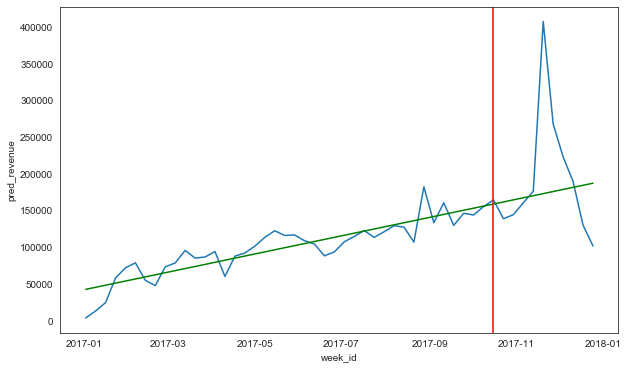

In [110]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=app_3,
             x="week_id",
             y="revenue",
             ax=ax);
sns.lineplot(data=app_3,
             x="week_id",
             y="pred_revenue",
             color="green");
ax.axvline(pd.to_datetime(first_week), color="r");

Calculate difference

In [114]:
baseline = baseline.assign(abs_diff=baseline["revenue"] - baseline["pred_revenue"])
baseline

,week_id,revenue,t,const,pred_revenue,manual_pred_revenue,abs_diff
42,2017-10-23,138558.520192,43,1,161393.082283,161396.4,-22834.562091
43,2017-10-30,144022.130485,44,1,164227.884860,164231.2,-20205.754375
44,2017-11-06,160327.020368,45,1,167062.687438,167066.0,-6735.667070
45,2017-11-13,175819.690094,46,1,169897.490015,169900.8,5922.200079
46,2017-11-20,407169.060410,47,1,172732.292593,172735.6,234436.767817
47,2017-11-27,267420.659656,48,1,175567.095171,175570.4,91853.564485
48,2017-12-04,222805.700109,49,1,178401.897748,178405.2,44403.802361
49,2017-12-11,189337.499647,50,1,181236.700326,181240.0,8100.799321
50,2017-12-18,129878.209996,51,1,184071.502903,184074.8,-54193.292907
51,2017-12-25,101439.800245,52,1,186906.305481,186909.6,-85466.505236


In [115]:
abs_diff_3 = baseline["abs_diff"].sum()
rel_diff_3 = abs_diff_3 / baseline["revenue"].sum()

In [116]:
print(f"""The revenue for the weeks influenced by the Black Friday promotion increased by {round(rel_diff_3 * 100, 2)}% 
compared to our baseline. Assuming the Black Friday promotion accounts for the entire difference, we were 
able to increase our revenue by {round(abs_diff_3, 2)} Reais""")

The revenue for the weeks influenced by the Black Friday promotion increased by 10.08% 
compared to our baseline. Assuming the Black Friday promotion accounts for the entire difference, we were 
able to increase our revenue by 195281.35 Reais


**Conclusion: We should definitely run the campaign again!**

# Approach 4: Fit a quadratic line

Find coefficients for the following model:

$revenue_t = const + t * trend + t^2 * trend_2$

In [136]:
app_4 = weekly_rev.loc[weekly_rev["week_id"] <= ub]

In [137]:
app_4 = (app_4
         .assign(t=range(1, len(app_4) + 1))
         .assign(const=1))
app_4.head()

,week_id,revenue,t,const
0,2017-01-02,3374.759989,1,1
1,2017-01-09,12937.239933,2,1
2,2017-01-16,24310.460104,3,1
3,2017-01-23,57773.149855,4,1
4,2017-01-30,71710.339832,5,1


In [138]:
app_4 = app_4.assign(t2=app_4["t"] ** 2)

In [140]:
X = app_4.loc[app_4["week_id"] <= first_week, ["const", "t", "t2"]]
y = app_4.loc[app_4["week_id"] <= first_week, "revenue"]

quad_reg = sm.OLS(y, X)
results_q = quad_reg.fit()

In [141]:
app_4_train = app_4.loc[app_4["week_id"] <= first_week]

In [142]:
app_4_train = app_4_train.assign(pred_revenue=results_q.predict(X))

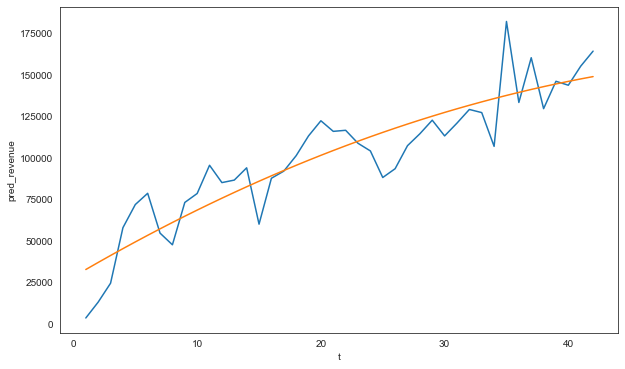

In [143]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=app_4_train,
             x="t",
             y="revenue");

sns.lineplot(data=app_4_train,
             x="t",
             y="pred_revenue",
             ax=ax);

**Conclusion: We should definitely run the campaign again!**